In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".root"])

# append to path
sys.path.append(str(root))

In [2]:
import math
from pathlib import Path

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Altitools
from alti_tools._src.data.ssh import download_ssh_toy
from alti_tools._src.transforms import spatial, temporal
from alti_tools._src.viz import psd as psd_plots
from alti_tools._src.preprocess.swot import preprocess_karin_swot
from alti_tools._src.utils.tracking import get_current_timestamp
from alti_tools._src.utils.files import list_all_files, check_list_equal_elem
from alti_tools._src.utils.files import check_if_directory, check_if_file
from alti_tools._src.data.configs.altimetry import get_raw_altimetry_config, get_raw_altimetry_files
from alti_tools._src.data.altimetry import load_alongtrack_parallel

import seaborn as sns
import corner

sns.set_context(context="talk", font_scale=0.7)


import xarray as xr
import pandas as pd
from scipy import ndimage
import holoviews as hv
import xrft
from dask.diagnostics import ProgressBar

import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

1. Download the Data
2. Check if all files are there
3. Load data for Training scenarios (1 NADIR, 4 NADIR, 1 SWOT, 1 SWOT + 4 NADIR)
4. Run experiment config for training
5. Run experiment config for evaluation

## Download

* AVISO (user, password)
  * security with yaml files
* MEOM Database
  * DataLakes (`raw`, `preprocess`, `ml_ready`, `results`, `post_process`) 

In [3]:
# TODO: download files from MEOM (given config)

# TODO: download files from AVISO (given config)

### Check Files

This is a simple script to ensure that all of the files necessary are there and available. In this dataset, we have two folders of files:
* `obs` - this refers to the pseudo-observations generated by the NADIR and SWOT tracks
* `ref` - this refers to the NATL60 free run simulation

In [4]:
from alti_tools._src.data.osse import check_osse_files

# check the NATL60 simulation files
ref_dir = "/Volumes/EMANS_HDD/data/dc20a_osse/raw/dc_ref"
check_osse_files(ref_dir, None, "ref")

# check the psuedo-obs files
obs_dir = "/Volumes/EMANS_HDD/data/dc20a_osse/raw/dc_obs"
check_osse_files(obs_dir, None, "obs")

### Datasets

In [5]:


data_config = get_raw_altimetry_config()
data_config

nadir:
- 2020a_SSH_mapping_NATL60_topex-poseidon_interleaved.nc
- 2020a_SSH_mapping_NATL60_envisat.nc
- 2020a_SSH_mapping_NATL60_geosat2.nc
- 2020a_SSH_mapping_NATL60_jason1.nc
swot:
- 2020a_SSH_mapping_NATL60_karin_swot.nc
swotnadir:
- 2020a_SSH_mapping_NATL60_nadir_swot.nc

#### NADIR Tracks

In [6]:
# display the raw altimetry datasets


In [7]:
# directory with the observations
obs_dir = "/Volumes/EMANS_HDD/data/dc20a_osse/raw/dc_obs"

# correct file types for datasets
obs_files = get_raw_altimetry_files(obs_dir, "nadir") 

# load them in parallel
ds_nadir = load_alongtrack_parallel(obs_files)

assert ds_nadir.coords["time"].shape == (205232,)

#### Demo Plots

In [8]:
from alti_tools._src.transforms.temporal import TimeCentralCoords
import datetime

In [9]:


# get coordinates of interest
central_date = datetime.datetime(year=2012, month=10, day=30)
delta_t = datetime.timedelta(days=1)

# create coordinates
plot_time_coords = TimeCentralCoords(central_date, delta_t)

plot_time_coords.tmin, plot_time_coords.tmax

(datetime.datetime(2012, 10, 29, 0, 0), datetime.datetime(2012, 10, 31, 0, 0))

In [10]:
def plot_demo_tracks(ds, time_coords):

    # subset
    plot_ds = ds.sel(time=slice(time_coords.tmin, time_coords.tmax))

    fig, ax = plt.subplots()

    pts = ax.scatter(plot_ds.lon % 360, plot_ds.lat, c=plot_ds.ssh_model, s=20, cmap="viridis")
    plt.colorbar(pts, ax=ax)

    return fig, ax

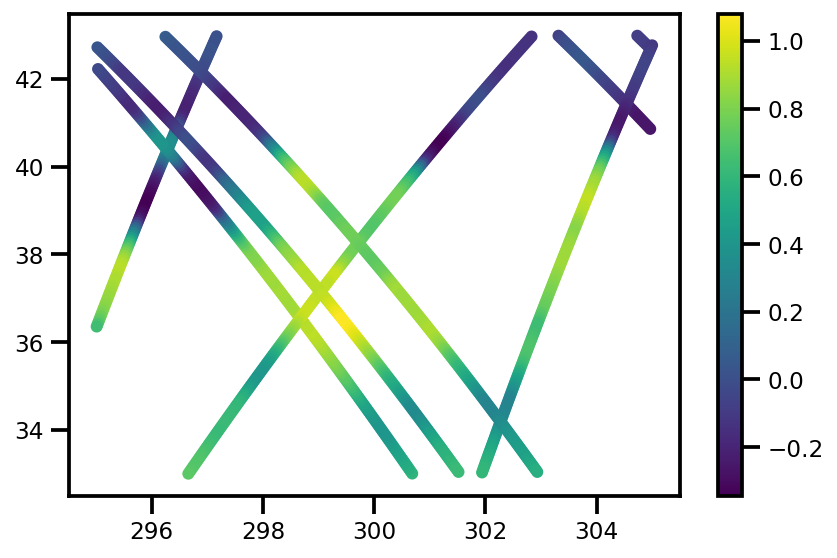

In [11]:
# plot demo
fig, ax = plot_demo_tracks(ds_nadir, plot_time_coords)

plt.tight_layout()
plt.show()

### SWOT Data

**KARIN Dataset**



In [12]:
file_path = get_raw_altimetry_files(obs_dir, "swot") 
file_path

# open stacked dataset
ds_swot_karin = xr.open_dataset(file_path[0])


In [13]:
# preprocess
ds_swot_karin = preprocess_karin_swot(ds_swot_karin, author="Emmanuel")

print(ds_swot_karin.attrs["mods_pre"])

# check shapes
assert ds_swot_karin.coords["time"].shape == (8_412_216,)

{'author': 'Emmanuel', 'time': '2022-11-02 15:00:03.276098+00:00', 'description': 'Alongtrack conversion: Flattened Array, Swapped dimensions, Sorted wrt time, pandas datetime'}


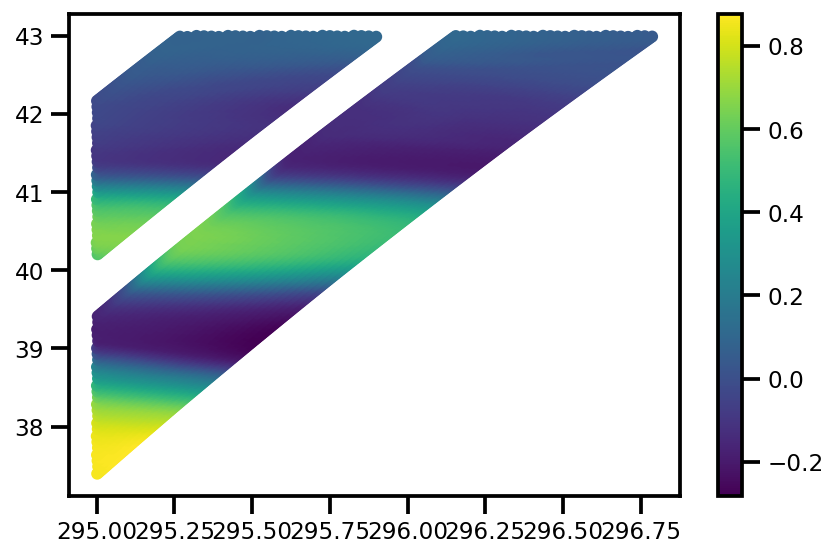

In [14]:

# plot demo
fig, ax = plot_demo_tracks(ds_swot_karin, plot_time_coords)

plt.tight_layout()
plt.show()

### SWOT NADIR

In [15]:
file_path = get_raw_altimetry_files(obs_dir, "swotnadir") 
file_path

# open stacked dataset
ds_nadir_swot = xr.open_dataset(file_path[0])

In [16]:
# select the first cycle
ds_nadir_swot = ds_nadir_swot.isel(cycle=0)

# check shapes
assert ds_nadir_swot.coords["time"].shape == (161_333, )

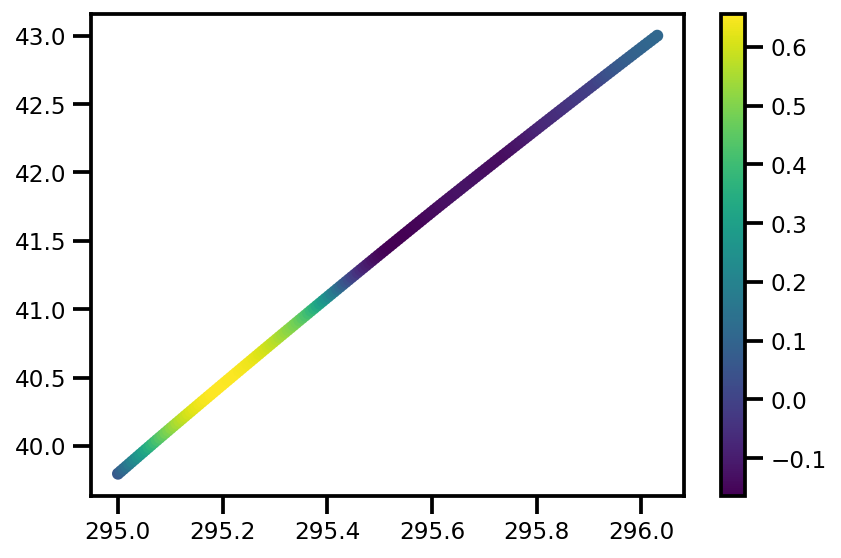

In [17]:
# plot demo
fig, ax = plot_demo_tracks(ds_nadir_swot, plot_time_coords)

plt.tight_layout()
plt.show()

### SWOT + NADIR

**TEST**: This is to ensure we will be able to concatentate these datasets later.

In [18]:
variables = ["ssh_obs", "ssh_model", "lon", "lat"]

ds_swot = xr.concat(
    [ds_nadir_swot[variables], ds_swot_karin[variables]], 
    dim="time", 
    data_vars=variables, coords=["time"]
)
# sort by time
ds_swot = ds_swot.sortby("time")

assert ds_swot.coords["time"].shape == (8573549,)

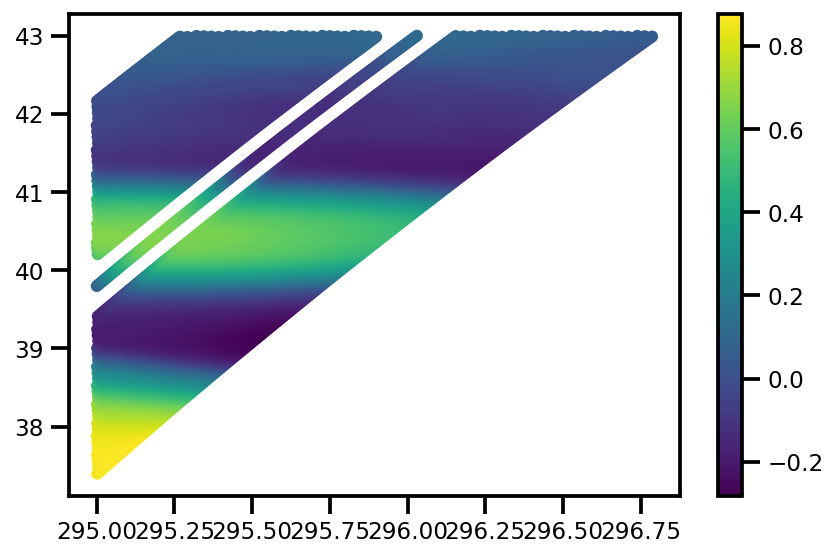

In [19]:
# plot demo
fig, ax = plot_demo_tracks(ds_swot, plot_time_coords)

plt.tight_layout()
plt.show()

Number of samples:

* NADIR4 - `205_232`
* SWOT - `8_412_216`
* SWOT NADIR - `161_333`

In [20]:
variables = ["ssh_obs", "ssh_model", "lon", "lat"]

ds_swot_nadir = xr.concat(
    [ds_swot[variables], ds_nadir[variables]], 
    dim="time", 
    data_vars=variables, coords=["time"]
)
# sort by time
ds_swot_nadir = ds_swot_nadir.sortby("time")

assert ds_swot_nadir.coords["time"].shape == (205_232 + 8_412_216 + 161_333,)

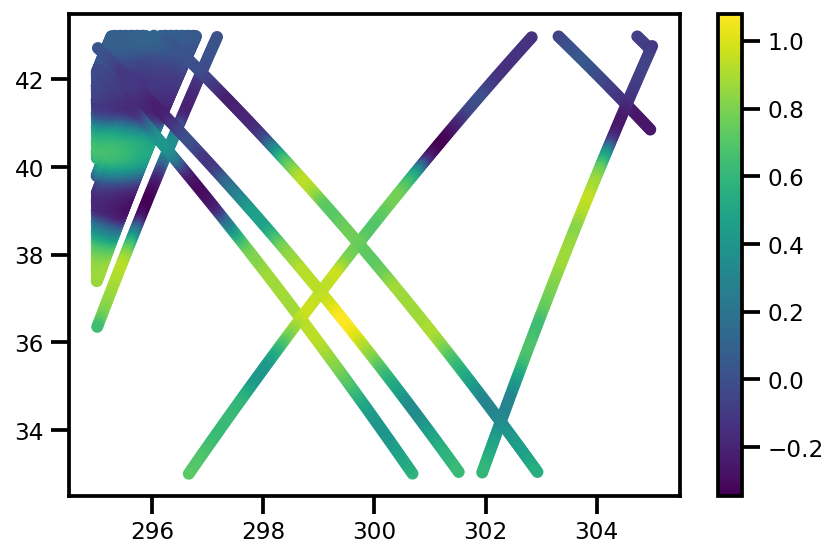

In [21]:
# plot demo
fig, ax = plot_demo_tracks(ds_swot_nadir, plot_time_coords)

plt.tight_layout()
plt.show()

### Density of Points

In [22]:
# grid = 365 * 201 * 201
# temp = obs_ds.ssh_obs.to_dataframe().dropna()
# real_obs = ds_swot_nadir4.coords["time"].shape[0]
# grid, temp.shape[0], 100*temp.shape[0]/grid , real_obs, 100*real_obs/grid
